В папке с заданием два датасета - data_orders - содержит выборку данных по заказам пользователей и включает такие колонки как:
* order_datetime -  время заказа
* origin_longitude - долгота
* origin_latitude - широта
* m_order_eta - время до прибытия машины
* order_gk - номер заказа
* order_status_key - статус (4 - отменен клиентом, 9 - отменен системой (reject))
* is_driver_assigned_key - был ли назначен водитель
* cancellations_time_in_seconds - сколько секунд прошло до отмены

data_offers - содержит пары номер заказа - ID оффера, который был предложен водителю по данному заказу.


В момент когда клиент нажимать на кнопку "Заказать" в приложении, система матчинга подыскивает наиболее релевантых водителей и предлагаем им заказ. В задании предлагается исследовать некоторые метрики матчинга для заказов, которые не завершились успешно (клиент в итоге не получил машину). 

#  **0.** Подготовка данных

Импортирую необходимые библиотеки, загружаю данные в pandas dataframe

In [183]:
## CODE HERE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
data_orders = pd.read_csv('data_orders.csv')
data_offers = pd.read_csv('data_offers.csv')

In [166]:
data_orders.head()
#Изучаю данные

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN


In [121]:
data_orders.info()
#Изучаю типы данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10716 entries, 0 to 10715
Data columns (total 8 columns):
order_datetime                   10716 non-null object
origin_longitude                 10716 non-null float64
origin_latitude                  10716 non-null float64
m_order_eta                      2814 non-null float64
order_gk                         10716 non-null int64
order_status_key                 10716 non-null int64
is_driver_assigned_key           10716 non-null int64
cancellations_time_in_seconds    7307 non-null float64
dtypes: float64(4), int64(3), object(1)
memory usage: 669.8+ KB


In [122]:
data_offers.head()

,order_gk,offer_id
0,3000579625629,300050936206
1,3000627306450,300052064651
2,3000632920686,300052408812
3,3000632771725,300052393030
4,3000583467642,300051001196


# **1.** Постройте распределение заказов по причинам неуспеха: отмены до и после назначения водителя, режекты

In [123]:
## CODE HERE
data_orders['order_status_key'].value_counts()
# проверяю данные на предмет уникальности, есть ли другие значения, кроме указанных выше.

4    7307
9    3409
Name: order_status_key, dtype: int64

In [124]:
data_orders['is_driver_assigned_key'].value_counts()
# проверяю данные на предмет уникальности, есть ли другие значения, кроме указанных выше.

0    7902
1    2814
Name: is_driver_assigned_key, dtype: int64

[Text(0, 0, 'клиент, автоматика'),
 Text(0, 0, 'водитель, автоматика'),
 Text(0, 0, 'клиент, ручной режим'),
 Text(0, 0, 'водитель, ручной режим')]

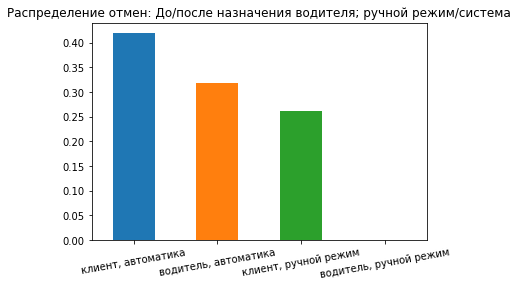

In [125]:

combined = data_orders['order_status_key'].astype('str')+' '+ data_orders['is_driver_assigned_key'].astype('str')
x = combined.value_counts(normalize = True).plot(kind = 'bar', title = 'Распределение отмен: До/после назначения водителя; ручной режим/система')
x.set_xticklabels(['клиент, автоматика','водитель, автоматика','клиент, ручной режим','водитель, ручной режим'],rotation = 10)


In [126]:
#from pandas.plotting import scatter_matrix
#scatter_matrix(data_orders[['order_status_key','is_driver_assigned_key']], figsize = (10,10))

* Похоже, что большинcтво причин отказов - отмены клиентом без назначения водителя. Возможно, клиенты заказывали такси по ошибке или передумывали. На втором месте - отмены системой без назначения водителя. Очевидно, что система не будет отменять заказ, если водитель уже назначен, поэтому  колонка, где идёт отмена системой и водитель назначен (9-1) на последнем месте.

[Text(0, 0, 'пассажиры'), Text(0, 0, 'водители')]

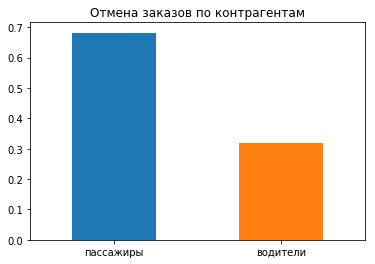

In [127]:
xticks = ['пассажиры', 'водители']
x = data_orders['order_status_key'].value_counts(normalize = True).plot(kind = 'bar', title = 'Отмена заказов по контрагентам')
x.set_xticklabels(xticks,rotation = 0)

Большинство отмен заказов произведены пассажирами, а не водителями, это достаточно очевидный вывод, связанный с тем, что пассажиры - клиенты и они довольно придирчиво могут выбирать такси, отказываться из-за дел и т.д. Но надо заметить, что количество отмен водителями достигает достаточно значительной доли от общего числа заказов. Это выглядит достаточно странно, т.к. водители получают за это деньги. Возможные причины - недостаток мотивации, усталость водителей.

[Text(0, 0, 'автоматический режим'), Text(0, 0, 'неавтоматический режим')]

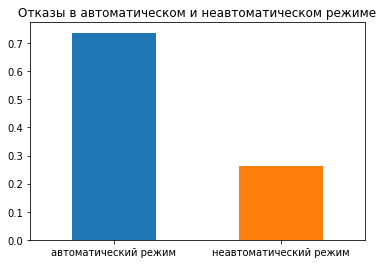

In [128]:
x = data_orders['is_driver_assigned_key'].value_counts(normalize = True)

fig, ax = plt.subplots()
ax = x.plot(kind = 'bar', rot = 0, title = 'Отказы в автоматическом и неавтоматическом режиме')
xticks = ['автоматический режим', 'неавтоматический режим']
ax.set_xticklabels(xticks)

Похоже, что большинство отказов происходило в автоматическом режиме. Скорее всего, предложения поездок идут сразу по нескольким водителям. Тот, кто откликнулся первым, получает заказ, остальным идёт отмена.

#  **2.** Постройте график распределения фейлов по часам - наблюдается ли тендеция, что в какие то часы доля той или иной категории аномально высока?

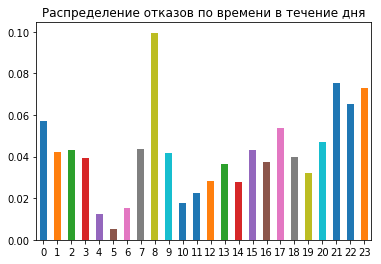

In [187]:
## CODE HERE
order_datetime_dt = pd.to_datetime(data_orders['order_datetime'])
order_datetime_dt = pd.Index(order_datetime_dt).hour
data_orders['order_datetime_dt'] = order_datetime_dt
data_orders['order_datetime_dt'].value_counts(normalize = True).sort_index(ascending=True).plot(rot = 0,kind = 'bar', title = 'Распределение отказов по времени в течение дня')


#### В какие часы фейлов больше всего? Чем это можно объяснить?

Мы видим, что пиковые часы отказов - в 8 часов, а также ближе к ночи с 9 вечера. Это связано, прежде всего, с общим количеством заказов. Утром люди едут на работу, берут такси, чтобы успеть на работу к 9 утра, вечером возвращаются с работы и берут такси. Соответственно, там, где пиковая нагрузка, идут и пиковые отказы. В течение дня количество отказов также зависит от количества поездок. К концу рабочего дня количество поездок увеличивается, вместе с ним увеличивается и количество отказов. 

Можно предположить, что вечерние пики отказов связаны с тем, что у людей нет необходимости пользоваться именно такси, нет такой спешки, есть альтернативный транспорт.

Утренний пик в восемь утра, думаю, можно объяснить конкуренцией с метро: люди могу передумать ехать на такси, так как утренний график очень плотный.

Ночные отказы, предполагаю, что связаны с высокой стоимостью поездки ночью: при увеличении стоимости поездки, растёт ценовая конкуренция между таксопарками.

#  **3**. Постройте графики среднего времени до отмены (cancellations_time_in_seconds) с водителем и без, по часам. Если есть выбросы в данных - лучше удалить. Можно ли сделать выводы по этому графику?

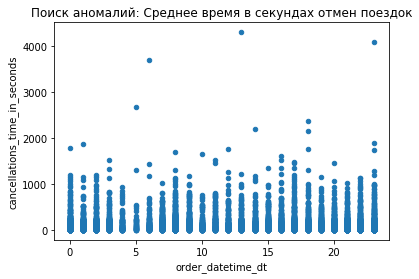

In [130]:
## CODE HERE
data_orders.plot(x = 'order_datetime_dt',y = 'cancellations_time_in_seconds',kind='scatter', title = 'Поиск аномалий: Среднее время в секундах отмен поездок')


Похоже, что если взять  отсечку в среднем времени отмены такси 2000 секунд, большинство выбросов по среднему времени ожидания такси можно отсечь без потерь для анализа данных. Это позволит сделать более точный анализ в дальнейшем

In [176]:
data_orders['cancellations_time_in_seconds'][data_orders['cancellations_time_in_seconds']>2000].value_counts()

2376.0    1
3697.0    1
4303.0    1
2680.0    1
2155.0    1
2190.0    1
4097.0    1
Name: cancellations_time_in_seconds, dtype: int64

7 записей не должны повлияять на общие выводы. Можно отсекать данные с временем ожидания такси более 2000 секунд без последствий для адекватности выводов.

In [185]:
data_orders['cancellations_time_in_seconds'][data_orders['cancellations_time_in_seconds']>2000].value_counts()

data_orders = data_orders[data_orders['cancellations_time_in_seconds']<2000]



(100, 250)

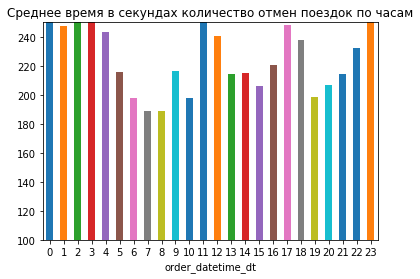

In [133]:
gr_bar = data_orders.groupby('order_datetime_dt')

x = gr_bar['cancellations_time_in_seconds'].agg(np.mean)
x.plot(kind = 'bar', rot = 0, title = 'Среднее время в секундах количество отмен поездок по часам').set_ylim(100,250)




В целом не выявляется какой-либо сильной зависимости времени отмен поездок от времени суток, если говорить об интегральных данных с и без назначения водителя. Есть пик в пять утра и просадка показателя вечером после 20:00. Пик в пять утра, возможно, связан с тем, что, в целом, водителей работает меньше в это время и клиенты вынуждены дольше терпеть, если водитель не успевает приехать. 

(50, 330)

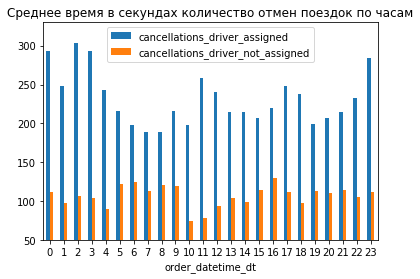

In [204]:


data_orders['cancellations_driver_assigned'] = data_orders['cancellations_time_in_seconds'][data_orders['is_driver_assigned_key']==1]
data_orders['cancellations_driver_not_assigned'] = data_orders['cancellations_time_in_seconds'][data_orders['is_driver_assigned_key']==0]
gr_bar = data_orders.groupby('order_datetime_dt')
x = gr_bar[['cancellations_driver_assigned','cancellations_driver_not_assigned']].agg(np.mean)


#data_orders

x.plot(kind = 'bar', rot = 0, title = 'Среднее время в секундах количество отмен поездок по часам').set_ylim(50,330)


#ax.set_xticklabels(xticks)


Опять же, можно обратить внимание на то, что время отмены без назначения водителя существенно ниже. Интересно, что среднее время в отменах без назначения водителя иногда не коррелирует с отменами с назначением водителей. Интересно также то, что если водитель не назначен с утра, то время отмены не сильно отличается от остального дня, зато при назначении водителя разница существенная. Если водитель назначен, то время отмены достаточно высоко ночью, это связано с тем, что, в целом, водителей ночью меньше. Пиков и сильных просадок без назначения водителя особо не наблюдается.

#  **4.** Постройте распределение среднего ЕТА по часам. Чем можно объяснить такой вид графика?

(250, 700)

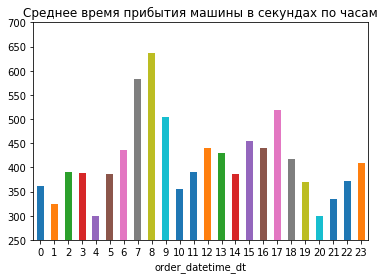

In [190]:
gr_bar['m_order_eta'].agg(np.mean).plot(title = 'Среднее время прибытия машины в секундах по часам',kind = 'bar', rot = 0).set_ylim(250,700)

## CODE HERE

Пиковые значения связаны загрузкой дорог и количеством заказов. Пиковая нагрузка утром, люди спешат на работу, такси стоит в пробках, движение затруднено. Это повторяется в 5 вечера, когда люди уезжают с работы и попадают опять в пробки. Количество заказов такси также выше всего утром и к концу рабочего дня.

#  5. Колонка drivers_offered - показывает сколько водителей увидели заказ и могли его принять. Постройте часовую разбивку среднего количества водителей которым был предложен заказ. Что можно сказать по ней про избыток/нехватку водителей в те или иные часы?

In [117]:
gr_offers = data_offers.groupby('order_gk')
data = gr_offers['offer_id'].agg(np.count_nonzero)

data_orders = data_orders.join(data, on = ['order_gk'], how = 'left')


      order_datetime  origin_longitude  origin_latitude  m_order_eta  \
0           18:08:07         -0.978916        51.456173         60.0   
2           12:07:50         -0.969520        51.455544        477.0   
3           13:50:20         -1.054671        51.460544        658.0   
13          16:55:28         -0.950683        51.451368        538.0   
14          00:59:26         -0.937006        51.448696        179.0   
20          13:21:15         -0.978916        51.456173         60.0   
21          12:57:52         -0.933755        51.446834        117.0   
22          08:37:53         -0.972037        51.456781        898.0   
26          08:59:15         -0.974281        51.475314        958.0   
27          22:59:25         -0.956267        51.443196        237.0   
28          22:41:17         -0.963063        51.449616        178.0   
33          01:23:42         -0.944732        51.443863        478.0   
37          20:30:04         -0.971564        51.458022         

In [105]:
data_orders = data_orders.rename(index=str, columns={"offer_id": "drivers_offered"})


(1.5, 5)

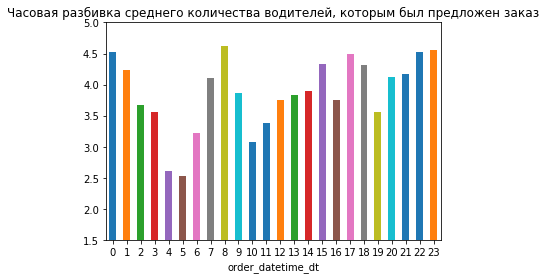

In [107]:
gr_bar = data_orders.groupby('order_datetime_dt')
gr_bar['drivers_offered'].agg(np.mean).plot(kind = 'bar',rot = 0, title = 'Часовая разбивка среднего количества водителей, которым был предложен заказ').set_ylim(1.5,5)

* Судя по диаграмме, можно сказать, что среднее количество водителей, которые смогли принять заказ колеблется от 2,5 водителей ночью до 4,5 водителей утром и вечером. Таким образом, конкуренция за заказ ниже всего ночью, а выше всего в часы пик. Также она растёт в течение дня

**6*.** Гексаконы.
Воспользовавшись пакетами h3 и folium, посчитайте, сколько гексагонов размера 8 (https://uber.github.io/h3/#/documentation/core-library/resolution-table) содержат 80% всех заказов из исходного датасета и визуализируйте гексагон с наибольшим количеством фейлов на карте.

##### Для дальнейшей аналитики потребуется установка библиотеки H3, как выяснилось, она имеет проблемы совместимости с операционными системами. Рекомендуется воспроизводить код на MacOS. Также ссылки на документацию с официального сайта библиотеки оказались не рабочими, документацию читал по ссылке с github https://nbviewer.jupyter.org/github/uber/h3-py-notebooks/tree/master/

In [20]:
import folium


#m = folium.Map( zoom_start = 20)
Location = data_orders[['origin_latitude','origin_longitude']]
print(Location.iloc[0])

m = folium.Map(
    location=Location.iloc[0],
    tiles='Stamen Terrain',
    zoom_start=11
)

m.add_child(folium.LatLngPopup())

folium.Circle(
    radius=100,
    location=Location.iloc[0],
    popup='The Waterfront',
    color='crimson',
    fill=False,
).add_to(m)

#folium.vector_layers.Polygon(Location, popup=None, tooltip=None, radius = 8).add_to(m)
from folium.plugins import HeatMap
HeatMap(Location).add_to(m)
m

#location


#folium.features.RegularPolygonMarker([51.45,-0.975], number_of_sides=6, rotation=0, radius=8, popup=None, tooltip=None,color='green').add_to(m)

#m


origin_latitude     51.456173
origin_longitude    -0.978916
Name: 0, dtype: float64


Для первоначальной визуализации данных использую тепловую карту из пакета folium

In [21]:
import json

from pandas.io.json import json_normalize
import numpy as np

import statistics

from geojson.feature import *
from area import area

import copy

from folium import Map, Marker, GeoJson
from folium.plugins import MarkerCluster
import branca.colormap as cm
from branca.colormap import linear
import folium

import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import Image, display
from IPython.utils.text import columnize
import warnings
warnings.filterwarnings('ignore')
from h3 import h3

#Импортируем необходимые библиоткеки

%matplotlib inline

In [118]:
cols = {"origin_latitude":"latitude","origin_longitude":"longitude"}

df_raw = Location.rename(columns = cols)
df_raw

#Переименовываю колонки для удобства

NameError: name 'Location' is not defined

In [25]:
def counts_by_hexagon(df, resolution):
    
    '''Use h3.geo_to_h3 to index each data point into the spatial index of the specified resolution.
      Use h3.h3_to_geo_boundary to obtain the geometries of these hexagons'''

    df = df[["latitude","longitude"]]
    
    df["hex_id"] = df.apply(lambda row: h3.geo_to_h3(row["latitude"], row["longitude"], resolution), axis = 1)
    
    df_aggreg = df.groupby(by = "hex_id").size().reset_index()
    df_aggreg.columns = ["hex_id", "value"]
    
    df_aggreg["geometry"] =  df_aggreg.hex_id.apply(lambda x: 
                                                           {    "type" : "Polygon",
                                                                 "coordinates": 
                                                                [h3.h3_to_geo_boundary(h3_address=x,geo_json=True)]
                                                            }
                                                        )
    
    return df_aggreg

Используем функции из документации библиотеки H3 для подсчёта количества данных в одном гексагоне и их аггрегации

In [26]:
df_aggreg = counts_by_hexagon(df = df_raw, resolution = 8)
print(df_aggreg.shape)
df_aggreg.sort_values(by = "value", ascending = False, inplace = True)
df_aggreg.quantile(0.8,interpolation = 'higher')


(108, 3)


value    25
Name: 0.8, dtype: int64

Используем pandas.Dataframe.quantile для подсчёта количества гексагонов, в которых находятся 80% фейлов

#### Ответ - 25 гексагонов содержат 80% всех фейлов по городу.

In [27]:
df_aggreg.sort_values(by = "value", ascending = False, inplace = True)
df_aggreg_new = df_aggreg[df_aggreg['value'] == df_aggreg['value'].max()].copy()

Подготовка для определения местонахождения маркера для гексагона, на который приходится большую часть фейлов

In [28]:
df_aggreg_new

,hex_id,value,geometry
75,88195d2b1dfffff,414,"{'type': 'Polygon', 'coordinates': [[[-0.96741..."


In [29]:
marker = list(df_aggreg_new['geometry'])[0]['coordinates'][0][0]
marker

[-0.9674195894273602, 51.462334241126385]

In [30]:
list(df_aggreg_new['geometry'])[0]['coordinates'][0][0]

[-0.9674195894273602, 51.462334241126385]

In [32]:
def hexagons_dataframe_to_geojson(df_hex, file_output = None):
    
    '''Produce the GeoJSON for a dataframe that has a geometry column in geojson format already, along with the columns hex_id and value '''
    
    list_features = []
    
    for i,row in df_hex.iterrows():
        feature = Feature(geometry = row["geometry"] , id=row["hex_id"], properties = {"value" : row["value"]})
        list_features.append(feature)
        
    feat_collection = FeatureCollection(list_features)
    
    geojson_result = json.dumps(feat_collection)
    
    #optionally write to file
    if file_output is not None:
        with open(file_output,"w") as f:
            json.dump(feat_collection,f)
    
    return geojson_result

In [31]:
def choropleth_map(df_aggreg, border_color = 'black', fill_opacity = 0.7, initial_map = None, with_legend = False,
                   kind = "linear"):
    #colormap
    min_value = df_aggreg["value"].min()
    max_value = df_aggreg["value"].max()
    m = round ((min_value + max_value ) / 2 , 0)
    
    #take resolution from the first row
    res = h3.h3_get_resolution(df_aggreg.loc[0,'hex_id'])
    
    if initial_map is None:
        initial_map = Map(location= [51.456173, -0.978916], zoom_start=11, tiles="cartodbpositron", 
                attr= '© <a href="http://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors © <a href="http://cartodb.com/attributions#basemaps">CartoDB</a>' 
            )
        

    #the colormap 
    #color names accepted https://github.com/python-visualization/branca/blob/master/branca/_cnames.json
    if kind == "linear":
        custom_cm = cm.LinearColormap(['green','yellow','red'], vmin=min_value, vmax=max_value)
    elif kind == "outlier":
        #for outliers, values would be -11,0,1
        custom_cm = cm.LinearColormap(['blue','white','red'], vmin=min_value, vmax=max_value)
    elif kind == "filled_nulls":
        custom_cm = cm.LinearColormap(['sienna','green','yellow','red'], 
                                      index=[0,min_value,m,max_value],vmin=min_value,vmax=max_value)
   

    #create geojson data from dataframe
    
    geojson_data = hexagons_dataframe_to_geojson(df_hex = df_aggreg)

    
    #plot on map
    name_layer = "Choropleth " + str(res)
    if kind != "linear":
        name_layer = name_layer + kind
        
    GeoJson(
        geojson_data,
        style_function=lambda feature: {
            'fillColor': custom_cm(feature['properties']['value']),
            'color': border_color,
            'weight': 1,
            'fillOpacity': fill_opacity 
        }, 
        name = name_layer
    ).add_to(initial_map)

    #add legend (not recommended if multiple layers)
    if with_legend == True:
        custom_cm.add_to(initial_map)
    
    
    
    return initial_map

Функции выше были взяты из документации и модифицированы (изменено метоположение по умолчанию). Ои помогают нарисовать карту, с помощью которой можно визуализировать гексагоны с заданным разрешением (в нашем случае разрешение = 8)

In [33]:
m_hex = choropleth_map(df_aggreg = df_aggreg, with_legend = True)


#marker = pd.Series(marker)
print(type(marker))
folium.Marker(marker).add_to(m)
print(marker)

m_hex.save('source/3_choropleth_counts_by_hexid9.html')


marker1 = [marker[1], marker[0]]
#Меняем координаты на корректные для построения маркера
print(marker1)
folium.Marker(marker1, popup='Максимальное значение гексагона').add_to(m_hex)
m_hex

<class 'list'>
[-0.9674195894273602, 51.462334241126385]
[51.462334241126385, -0.9674195894273602]


In [34]:
df_aggreg.max()

hex_id    88195d74d7fffff
value                 414
dtype: object

В гексагоне размера 8, в котором находится максимальное количество фейлов находится 414 фейлов

In [37]:
df_aggreg_8 = counts_by_hexagon(df = df_raw, resolution = 8)
df_aggreg_7 = counts_by_hexagon(df = df_raw, resolution = 7)
df_aggreg_6 = counts_by_hexagon(df = df_raw, resolution = 6)

m_hex_9 = choropleth_map(df_aggreg = df_aggreg, with_legend = False)
m_hex_8 = choropleth_map(df_aggreg = df_aggreg_8, initial_map = m_hex_9, with_legend = False)
m_hex_7 = choropleth_map(df_aggreg = df_aggreg_7, initial_map = m_hex_8, with_legend = False)
m_hex_6 = choropleth_map(df_aggreg = df_aggreg_6, initial_map = m_hex_7, with_legend = False)

folium.map.LayerControl('bottomright', collapsed=False).add_to(m_hex_6)

m_hex_6.save('source/4_choropleth_res8.html')
m_hex_6
#display(m_hex_6)

Дополнительная визуализация, показывает увеличение плотности по гексагонам с изменением разрешения

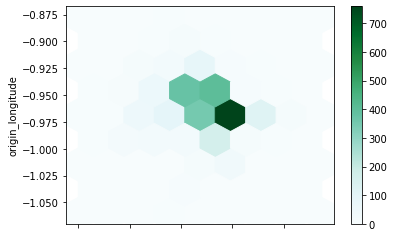

In [19]:
fig = plt.figure
plt.xticks
data_orders.plot.hexbin(x='origin_latitude', y='origin_longitude', gridsize=8, legend = True)
plt.xticks(rotation = 90)
plt.show()

Вариант с использованием гексагональной визуализации в Matplotlib. Разрешения различается с библиотекой H3